In [78]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import dataset, config, layers, warm_start, plot

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(config.RANDOM_SEED)

In [3]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    int(1e+6),
    config.min_lenght, config.pallet_lenght, 
    config.min_width, config.pallet_width, 
    config.min_height, config.max_product_height, 
    config.min_weight, config.pallet_load,
    force_overload=False
)
product_dataset.products.head()

,lenght,width,height,weight,volume
0,168,217,173,23,6306888
1,376,612,316,2,72715392
2,382,475,211,8,38285950
3,290,487,261,20,36861030
4,106,156,159,15,2629224


In [4]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
order.head()

,id,lenght,width,height,weight,volume
0,121958,231,252,80,9,4656960
1,671155,146,201,115,89,3374790
2,131932,222,279,190,23,11768220
3,365838,195,284,182,26,10079160
4,259178,190,237,54,2,2431620


To do:
- Write bin packing heuristics
- Add weight constraints
- Struttura gestione layers
- Da coordinate superitem a coordinate item

In [67]:
sample_order = pd.concat([order.sample(1)] * 10 + [order.sample(1)] * 10 + [order.sample(1)] * 10).reset_index(drop=True)
sample_order

,id,lenght,width,height,weight,volume
0,764469,155,199,73,4,2251685
1,764469,155,199,73,4,2251685
2,764469,155,199,73,4,2251685
3,764469,155,199,73,4,2251685
4,764469,155,199,73,4,2251685
5,764469,155,199,73,4,2251685
6,764469,155,199,73,4,2251685
7,764469,155,199,73,4,2251685
8,764469,155,199,73,4,2251685
9,764469,155,199,73,4,2251685


In [5]:
from ortools.linear_solver import pywraplp

status_string = {
    cp_model.OPTIMAL: 'optimal',
    cp_model.FEASIBLE: 'feasible',
    cp_model.INFEASIBLE: 'infeasible',
    cp_model.MODEL_INVALID: 'invalid',
    cp_model.UNKNOWN: 'unknown'
}

def main_problem(fsi, zsl, ol, tlim=None, relaxation=True):
    # fsi: boolean matrix fsi[s, i] = 1 if superitem s contains item i  
    # zsl: boolean matrix zsl[s, l] = 1 if superitem s is in layer l
    # ol: continuos variables ol[l] = h if layer l has height h
    
    # Solver
    if relaxation:
        slv = pywraplp.Solver.CreateSolver('CLP')
    else:
        slv = pywraplp.Solver.CreateSolver('CBC')
    
    # Utility
    infinity = slv.infinity()
    n_superitems, n_layers = zsl.shape
    n_items = fsi.shape[-1] 
    
    # Variables
    if relaxation:
        al = [
            slv.NumVar(0, infinity, f'alpha_{l}') 
            for l in range(n_layers)
        ]
    else:
        al = [
            slv.IntVar(0, 1, f'alpha_{l}') 
            for l in range(n_layers)
        ]
        
    # Constraints
    for i in range(n_items):
        if relaxation:
            slv.Add(
                -sum(
                    fsi[s, i] * zsl[s, l] * al[l] 
                    for s in range(n_superitems) 
                    for l in range(n_layers)
                ) <= -1
            )
        else:
            slv.Add(
                sum(
                    fsi[s, i] * zsl[s, l] * al[l] 
                    for s in range(n_superitems) 
                    for l in range(n_layers)
                ) >= 1
            )
    
    # Objective
    obj = sum(h * al[l] for l, h in enumerate(ol))
    if relaxation:
        slv.Minimize(obj)
    else:
        slv.Maximize(-obj)
        
    # Set a time limit
    if tlim is not None:
        slv.SetTimeLimit(1000 * tlim)
        
    # Solve
    status = slv.Solve()
    
    # Extract results
    sol, duals = None, None
    if status in (slv.OPTIMAL, slv.FEASIBLE):
        sol = {
            f'alpha_{l}': al[l].solution_value() for l in range(n_layers)
        }
        sol['objective'] = slv.Objective().Value()
        if relaxation:
            duals = np.array([-c.dual_value() for c in slv.constraints()])
    
    # Return results
    return sol, slv.WallTime() / 1000, duals

In [60]:
def pricing_problem_no_placement(fsi, ws, ds, hs, W, D, duals, feasibility=None, tlim=None):
    # Solver
    slv = pywraplp.Solver.CreateSolver('CBC')
    
    # Utility
    infinity = slv.infinity()
    n_superitems, n_items = fsi.shape
    
    # Variables
    ol = slv.NumVar(0, infinity, f'o_l') 
    zsl = [
        slv.IntVar(0, 1, f'z_{s}_l') 
        for s in range(n_superitems)
    ]
    
    # Constraints
    # Redundant valid cuts that force the area of 
    # a layer to fit within the area of a bin
    slv.Add(
        sum(
            ws[s] * ds[s] * zsl[s]
            for s in range(n_superitems)
        ) <= W * D
    )
    for s in range(n_superitems):
        # Define the height of layer l
        slv.Add(ol >= hs[s] * zsl[s])
    
    # Enforce feasible placement
    if feasibility is not None:
        print("Adding feasibility constraint...")
        slv.Add(
            sum(zsl[s] for s in range(n_superitems)) <= 
            feasibility - 1
        )
    
    # Objective
    obj = ol - sum(
        duals[i] * fsi[s, i] * zsl[s]
        for i in range(n_items)
        for s in range(n_superitems)
    ) 
    slv.Minimize(obj)
    
    # Set a time limit
    if tlim is not None:
        slv.SetTimeLimit(1000 * tlim)
        
    # Solve
    status = slv.Solve()
    
    # Extract results
    sol = dict()
    if status in (slv.OPTIMAL, slv.FEASIBLE):
        sol[f'o_l'] = ol.solution_value()
        for s in range(n_superitems):
            sol[f'z_{s}_l'] = zsl[s].solution_value()
        sol['objective'] =  slv.Objective().Value()
    
    return sol, slv.WallTime() / 1000

In [7]:
def pricing_problem_placement(layer_height, 
                              superitems, 
                              items, 
                              fsi, 
                              ws, 
                              ds, 
                              hs, 
                              W, 
                              D, 
                              duals, 
                              tlim=None):
    # Solver
    slv = pywraplp.Solver.CreateSolver('CBC')
    
    # Utility
    infinity = slv.infinity()
    
    # Variables
    zsl = {
        s: slv.IntVar(0, 1, f'z_{s}_l') 
        for s in superitems
    }
    cix = {
        s: slv.IntVar(0, int(W - ws[s]), f'c_{s}_x')
        for s in superitems
    }
    ciy = {
        s: slv.IntVar(0, int(D - ds[s]), f'c_{s}_y')
        for s in superitems
    }
    xsj, ysj = dict(), dict()
    for s in superitems:
        for j in superitems:
            if j != s:
                xsj[(s, j)] = slv.IntVar(0, 1, f'x_{s}_{j}')
                ysj[(s, j)] = slv.IntVar(0, 1, f'y_{s}_{j}')
    
    # Constraints
    # Redundant valid cuts that force the area of 
    # a layer to fit within the area of a bin
    slv.Add(
        sum(
            ws[s] * ds[s] * zsl[s]
            for s in superitems
        ) <= W * D
    )
    
    for s in superitems:
        # Define the height of layer l
        slv.Add(layer_height >= hs[s] * zsl[s])
            
    # Enforce at least one relative positioning relationship
    # between each pair of items in a layer
    for s in superitems:
        for j in superitems:
            if j > s:
                slv.Add(
                    xsj[s, j] + xsj[j, s] + ysj[s, j] + ysj[j, s] >= 
                    zsl[s] + zsl[j] - 1
                )
                
    # Ensure that there is at most one spatial relationship 
    # between items i and j along the width and depth dimensions
    for s in superitems:
        for j in superitems:
            if j > s:
                slv.Add(
                    xsj[s, j] + xsj[j, s] <= 1
                )
                slv.Add(
                    ysj[s, j] + ysj[j, s] <= 1
                )
    
    # Non-overlapping constraints
    for s in superitems:
        for j in superitems:
            if j != s:
                slv.Add(
                    cix[s] + ws[s] <= cix[j] + W * (1 - xsj[s, j])
                )
                slv.Add(
                    ciy[s] + ds[s] <= ciy[j] + D * (1 - ysj[s, j])
                )
    
    # Objective
    obj = layer_height - sum(
        duals[i] * fsi[s, i] * zsl[s]
        for i in items
        for s in superitems
    )
    slv.Minimize(obj)
    
    # Set a time limit
    if tlim is not None:
        slv.SetTimeLimit(1000 * tlim)
        
    # Solve
    status = slv.Solve()
    
    # Extract results
    sol = dict()
    if status in (slv.OPTIMAL, slv.FEASIBLE):
        for s in superitems:
            sol[f'z_{s}_l'] = zsl[s].solution_value()
            sol[f'c_{s}_x'] = cix[s].solution_value()
            sol[f'c_{s}_y'] = ciy[s].solution_value()
        sol['objective'] =  slv.Objective().Value()
    
    return sol, slv.WallTime() / 1000

In [8]:
def np_are_equal(a1, a2):
    if a1.shape != a2.shape:
        return False
    return np.count_nonzero(a1 - a2) == 0

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

In [30]:
def column_generation(fsi, zsl, ol, ws, ds, hs, W, D, max_iter=20, max_stag_iters=20, tlim=None, tol=1e-3):
    layer_pool = []
    n_superitems, n_items = fsi.shape
    best_rmp_obj, num_stag_iters = float('inf'), 0 
    for _ in tqdm(range(max_iter)):
        # Reduced master problem
        print("Solving RMP...")
        rmp_sol, rmp_time, duals = main_problem(
            fsi, zsl, ol, tlim=tlim, relaxation=True
        )
        print("Duals:", duals)
        
        # Keep best RMP objective value
        if rmp_sol['objective'] < best_rmp_obj:
            best_rmp_obj = rmp_sol['objective']
            num_stag_iters = 0
        else:
            num_stag_iters += 1
            
        # Break if RMP objective does not improve
        if num_stag_iters == max_stag_iters:
            break
        
        # Check feasibility
        n_layers = zsl.shape[-1]
        print("Alpha:", [rmp_sol[f'alpha_{l}'] for l in range(n_layers)])
        if not all([rmp_sol[f'alpha_{l}'] in (0, 1) for l in range(n_layers)]):
            print("RMP: solution not feasible (at least one alpha value is not binary)")
        
        # Pricing sub-problem
        feasibility, placed = None, False
        while not placed: 
            print("Solving SP (no placement)...")
            sp_np_sol, sp_np_time = pricing_problem_no_placement(
                fsi, ws, ds, hs, W, D, duals, feasibility=feasibility, tlim=tlim
            )
            np_superitems_in_layer = [
                s for s in range(n_superitems) 
                if sp_np_sol[f'z_{s}_l'] == 1
            ]
            np_items_in_layer = [
                i for i in range(n_items) for s in range(n_superitems)
                if fsi[s, i] == 1
            ]
            feasibility = len(np_superitems_in_layer)

            # Non-negative reduced cost
            print("Reduced cost:", sp_np_sol['objective'])
            if sp_np_sol['objective'] >= 0:
                print("Reached convergence :)")
                return layer_pool
            
            print("Solving SP (with placement)...")
            sp_p_sol, sp_p_time = pricing_problem_placement(
                sp_np_sol['o_l'],
                np_superitems_in_layer, 
                np_items_in_layer, 
                fsi, ws, ds, hs, W, D, duals, tlim=tlim
            )
            placed = 'objective' in sp_p_sol
            
            if placed:
                zsl_layer = np.zeros((n_superitems, 1), dtype=int)
                zsl_layer[np_superitems_in_layer] = np.array([
                    sp_p_sol[f'z_{s}_l'] for s in np_superitems_in_layer
                ]).reshape(-1, 1)
                p_superitems_in_layer = zsl_layer.nonzero()[0]
                coords = np.array([(sp_p_sol[f'c_{s}_x'], sp_p_sol[f'c_{s}_y']) for s in p_superitems_in_layer], dtype=int)

                # Check if layer is a duplicate
                duplicate = False
                for other_layer in layer_pool:
                    if np_are_equal(other_layer[1], p_superitems_in_layer) and np_are_equal(other_layer[2], coords):
                        duplicate = True
                        break
                
                # Store layer in the pool 
                if not duplicate:
                    layer_pool += [(
                        int(np.ceil(sp_np_sol[f'o_l'])), # layer height
                        p_superitems_in_layer, # superitems in layer
                        coords # x, y coordinates of superitems in layer
                    )]
                    
                zsl = np.concatenate((zsl, zsl_layer), axis=1)
                ol = np.concatenate((ol, [np.ceil(sp_np_sol[f'o_l'])]))
                    
    return layer_pool

## Superitems generation

In [72]:
superitems, ws, ds, hs = layers.generate_superitems(
    order, (config.pallet_lenght, config.pallet_width, config.max_product_height), max_stacked_items=4
)
superitems

Generating horizontal 2-items superitems: 0it [00:00, ?it/s]
Generating horizontal 4-items superitems: 0it [00:00, ?it/s]


,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,[76],94,178,154,2,2576728,False,[76],1
1,[10],133,189,236,2,5932332,False,[10],1
2,[43],161,160,191,2,4920160,False,[43],1
3,[70],140,196,157,35,4308080,False,[70],1
4,[91],143,195,121,23,3374085,False,[91],1
...,...,...,...,...,...,...,...,...,...
198,"[[30], [8], [59], [19]]",275,440,653,66,71544780,True,"[30, 8, 59, 19]",4
199,"[[35], [46], [75], [24]]",302,462,584,32,69678974,True,"[35, 46, 75, 24]",4
200,"[[34], [63], [13], [92]]",323,432,743,248,92741508,True,"[34, 63, 13, 92]",4
201,"[[61], [50], [26], [33]]",323,455,717,32,96418706,True,"[61, 50, 26, 33]",4


In [73]:
superitems[superitems.vstacked].shape

(103, 9)

## Warm start with height groups

In [74]:
initial_groups = warm_start.get_initial_groups(superitems, tol=5)
for group in initial_groups:
    display(group)

,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,17,[4],190,237,54,2,2431620,False,[4],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,97,[90],467,505,60,94,14150100,False,[90],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,7,[93],155,199,73,4,2251685,False,[93],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,37,[0],231,252,80,9,4656960,False,[0],1
1,44,[22],230,286,82,17,5393960,False,[22],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,44,[22],230,286,82,17,5393960,False,[22],1
1,86,[13],309,403,86,7,10709322,False,[13],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,67,[49],284,304,95,233,8201920,False,[49],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,66,[15],260,321,102,8,8512920,False,[15],1
1,80,[35],291,394,104,3,11924016,False,[35],1
2,81,[46],280,419,107,2,12553240,False,[46],1
3,93,[25],315,481,104,11,15757560,False,[25],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,34,[78],210,265,108,4,6010200,False,[78],1
1,80,[35],291,394,104,3,11924016,False,[35],1
2,81,[46],280,419,107,2,12553240,False,[46],1
3,93,[25],315,481,104,11,15757560,False,[25],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,14,[16],170,260,112,7,4950400,False,[16],1
1,34,[78],210,265,108,4,6010200,False,[78],1
2,81,[46],280,419,107,2,12553240,False,[46],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,14,[16],170,260,112,7,4950400,False,[16],1
1,34,[78],210,265,108,4,6010200,False,[78],1
2,78,[59],274,411,113,15,12725382,False,[59],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,6,[1],146,201,115,89,3374790,False,[1],1
1,14,[16],170,260,112,7,4950400,False,[16],1
2,24,[17],171,290,116,5,5752440,False,[17],1
3,49,[21],211,329,117,4,8122023,False,[21],1
4,78,[59],274,411,113,15,12725382,False,[59],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,4,[91],143,195,121,23,3374085,False,[91],1
1,24,[17],171,290,116,5,5752440,False,[17],1
2,49,[21],211,329,117,4,8122023,False,[21],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,47,[41],227,302,131,6,8980574,False,[41],1
1,90,[26],316,434,127,2,17417288,False,[26],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,19,[66],167,276,134,32,6176328,False,[66],1
1,22,[72],191,258,134,2,6603252,False,[72],1
2,31,[85],196,279,133,2,7272972,False,[85],1
3,47,[41],227,302,131,6,8980574,False,[41],1
4,69,[71],247,364,133,8,11957764,False,[71],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,19,[66],167,276,134,32,6176328,False,[66],1
1,22,[72],191,258,134,2,6603252,False,[72],1
2,29,[79],214,241,138,9,7117212,False,[79],1
3,31,[85],196,279,133,2,7272972,False,[85],1
4,36,[94],200,290,138,7,8004000,False,[94],1
5,69,[71],247,364,133,8,11957764,False,[71],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,29,[79],214,241,138,9,7117212,False,[79],1
1,36,[94],200,290,138,7,8004000,False,[94],1
2,70,[53],231,408,140,176,13194720,False,[53],1
3,72,[81],236,415,140,2,13711600,False,[81],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,5,[58],146,199,149,10,4329046,False,[58],1
1,9,[32],142,241,150,2,5133300,False,[32],1
2,50,[55],224,310,148,19,10277120,False,[55],1
3,59,[18],254,291,151,11,11161014,False,[18],1
4,71,[87],270,360,150,2,14580000,False,[87],1
5,96,[37],342,588,146,49,29360016,False,[37],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,5,[58],146,199,149,10,4329046,False,[58],1
1,9,[32],142,241,150,2,5133300,False,[32],1
2,11,[88],147,243,152,5,5429592,False,[88],1
3,50,[55],224,310,148,19,10277120,False,[55],1
4,59,[18],254,291,151,11,11161014,False,[18],1
5,71,[87],270,360,150,2,14580000,False,[87],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,0,[76],94,178,154,2,2576728,False,[76],1
1,5,[58],146,199,149,10,4329046,False,[58],1
2,9,[32],142,241,150,2,5133300,False,[32],1
3,11,[88],147,243,152,5,5429592,False,[88],1
4,59,[18],254,291,151,11,11161014,False,[18],1
5,71,[87],270,360,150,2,14580000,False,[87],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,0,[76],94,178,154,2,2576728,False,[76],1
1,8,[51],146,234,155,2,5295420,False,[51],1
2,9,[32],142,241,150,2,5133300,False,[32],1
3,11,[88],147,243,152,5,5429592,False,[88],1
4,59,[18],254,291,151,11,11161014,False,[18],1
5,71,[87],270,360,150,2,14580000,False,[87],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,0,[76],94,178,154,2,2576728,False,[76],1
1,3,[70],140,196,157,35,4308080,False,[70],1
2,8,[51],146,234,155,2,5295420,False,[51],1
3,11,[88],147,243,152,5,5429592,False,[88],1
4,35,[74],173,332,157,38,9017452,False,[74],1
5,64,[82],220,368,157,181,12710720,False,[82],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,3,[70],140,196,157,35,4308080,False,[70],1
1,8,[51],146,234,155,2,5295420,False,[51],1
2,35,[74],173,332,157,38,9017452,False,[74],1
3,53,[83],236,298,160,18,11252480,False,[83],1
4,64,[82],220,368,157,181,12710720,False,[82],1
5,75,[64],237,443,160,4,16798560,False,[64],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,3,[70],140,196,157,35,4308080,False,[70],1
1,13,[29],186,235,162,2,7081020,False,[29],1
2,35,[74],173,332,157,38,9017452,False,[74],1
3,53,[83],236,298,160,18,11252480,False,[83],1
4,64,[82],220,368,157,181,12710720,False,[82],1
5,75,[64],237,443,160,4,16798560,False,[64],1
6,77,[8],251,429,162,2,17443998,False,[8],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,13,[29],186,235,162,2,7081020,False,[29],1
1,30,[57],167,319,163,12,8683499,False,[57],1
2,53,[83],236,298,160,18,11252480,False,[83],1
3,61,[99],259,293,164,5,12445468,False,[99],1
4,75,[64],237,443,160,4,16798560,False,[64],1
5,77,[8],251,429,162,2,17443998,False,[8],1
6,98,[62],460,516,164,2,38927040,False,[62],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,13,[29],186,235,162,2,7081020,False,[29],1
1,30,[57],167,319,163,12,8683499,False,[57],1
2,61,[99],259,293,164,5,12445468,False,[99],1
3,68,[84],253,346,166,236,14531308,False,[84],1
4,77,[8],251,429,162,2,17443998,False,[8],1
5,98,[62],460,516,164,2,38927040,False,[62],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,32,[36],219,252,169,13,9326772,False,[36],1
1,61,[99],259,293,164,5,12445468,False,[99],1
2,68,[84],253,346,166,236,14531308,False,[84],1
3,98,[62],460,516,164,2,38927040,False,[62],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,32,[36],219,252,169,13,9326772,False,[36],1
1,55,[42],246,292,170,3,12211440,False,[42],1
2,65,[69],236,350,170,4,14042000,False,[69],1
3,68,[84],253,346,166,236,14531308,False,[84],1
4,82,[75],302,400,170,25,20536000,False,[75],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,32,[36],219,252,169,13,9326772,False,[36],1
1,55,[42],246,292,170,3,12211440,False,[42],1
2,65,[69],236,350,170,4,14042000,False,[69],1
3,82,[75],302,400,170,25,20536000,False,[75],1
4,89,[50],293,455,174,2,23196810,False,[50],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,15,[89],179,248,176,2,7812992,False,[89],1
1,26,[47],170,298,177,2,8966820,False,[47],1
2,58,[14],224,329,177,2,13044192,False,[14],1
3,60,[48],219,345,177,4,13373235,False,[48],1
4,79,[19],275,412,178,45,20167400,False,[19],1
5,89,[50],293,455,174,2,23196810,False,[50],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,15,[89],179,248,176,2,7812992,False,[89],1
1,25,[28],178,282,180,46,9035280,False,[28],1
2,26,[47],170,298,177,2,8966820,False,[47],1
3,54,[97],201,356,181,119,12951636,False,[97],1
4,58,[14],224,329,177,2,13044192,False,[14],1
5,60,[48],219,345,177,4,13373235,False,[48],1
6,79,[19],275,412,178,45,20167400,False,[19],1
7,94,[39],320,496,180,4,28569600,False,[39],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,25,[28],178,282,180,46,9035280,False,[28],1
1,26,[47],170,298,177,2,8966820,False,[47],1
2,33,[3],195,284,182,26,10079160,False,[3],1
3,54,[97],201,356,181,119,12951636,False,[97],1
4,58,[14],224,329,177,2,13044192,False,[14],1
5,60,[48],219,345,177,4,13373235,False,[48],1
6,79,[19],275,412,178,45,20167400,False,[19],1
7,94,[39],320,496,180,4,28569600,False,[39],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,33,[3],195,284,182,26,10079160,False,[3],1
1,91,[33],323,432,187,20,26093232,False,[33],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,102,"[[1], [93]]",155,201,188,93,5626475,True,"[1, 93]",2
1,2,[43],161,160,191,2,4920160,False,[43],1
2,40,[2],222,279,190,23,11768220,False,[2],1
3,74,[86],247,401,188,12,18620836,False,[86],1
4,91,[33],323,432,187,20,26093232,False,[33],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,132,"[[15], [49]]",284,321,197,241,16714840,True,"[15, 49]",2
1,39,[73],242,248,199,4,11943184,False,[73],1
2,43,[27],200,315,197,2,12411000,False,[27],1
3,76,[30],241,440,200,4,21208000,False,[30],1
4,92,[52],323,433,197,3,27552223,False,[52],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,39,[73],242,248,199,4,11943184,False,[73],1
1,76,[30],241,440,200,4,21208000,False,[30],1
2,83,[24],263,462,203,2,24665718,False,[24],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,48,[77],217,318,205,11,14146230,False,[77],1
1,76,[30],241,440,200,4,21208000,False,[30],1
2,83,[24],263,462,203,2,24665718,False,[24],1
3,87,[92],323,394,205,38,26088710,False,[92],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,147,"[[37], [90]]",467,588,206,143,43510116,True,"[37, 90]",2
1,48,[77],217,318,205,11,14146230,False,[77],1
2,83,[24],263,462,203,2,24665718,False,[24],1
3,87,[92],323,394,205,38,26088710,False,[92],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,147,"[[37], [90]]",467,588,206,143,43510116,True,"[37, 90]",2
1,23,[31],192,258,210,25,10402560,False,[31],1
2,48,[77],217,318,205,11,14146230,False,[77],1
3,87,[92],323,394,205,38,26088710,False,[92],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,139,"[[35], [46]]",291,419,211,5,24477256,True,"[35, 46]",2
1,147,"[[37], [90]]",467,588,206,143,43510116,True,"[37, 90]",2
2,18,[54],172,264,211,2,9581088,False,[54],1
3,23,[31],192,258,210,25,10402560,False,[31],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,139,"[[35], [46]]",291,419,211,5,24477256,True,"[35, 46]",2
1,18,[54],172,264,211,2,9581088,False,[54],1
2,23,[31],192,258,210,25,10402560,False,[31],1
3,73,[38],277,356,213,10,21004356,False,[38],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,117,"[[94], [0]]",231,290,218,16,12660960,True,"[94, 0]",2
1,42,[67],220,286,218,2,13716560,False,[67],1
2,73,[38],277,356,213,10,21004356,False,[38],1
3,84,[34],298,413,218,2,26830132,False,[34],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,117,"[[94], [0]]",231,290,218,16,12660960,True,"[94, 0]",2
1,42,[67],220,286,218,2,13716560,False,[67],1
2,51,[65],208,337,219,4,15351024,False,[65],1
3,84,[34],298,413,218,2,26830132,False,[34],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,10,[68],144,246,232,21,8218368,False,[68],1
1,28,[40],182,281,232,2,11864944,False,[40],1
2,56,[12],221,331,227,5,16605277,False,[12],1
3,88,[61],318,408,229,8,29711376,False,[61],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,10,[68],144,246,232,21,8218368,False,[68],1
1,28,[40],182,281,232,2,11864944,False,[40],1
2,85,[63],288,432,234,201,29113344,False,[63],1
3,88,[61],318,408,229,8,29711376,False,[61],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,1,[10],133,189,236,2,5932332,False,[10],1
1,10,[68],144,246,232,21,8218368,False,[68],1
2,28,[40],182,281,232,2,11864944,False,[40],1
3,41,[6],171,364,235,72,14627340,False,[6],1
4,85,[63],288,432,234,201,29113344,False,[63],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,1,[10],133,189,236,2,5932332,False,[10],1
1,20,[7],191,247,239,3,11275303,False,[7],1
2,41,[6],171,364,235,72,14627340,False,[6],1
3,85,[63],288,432,234,201,29113344,False,[63],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,21,[98],214,225,251,24,12085650,False,[98],1
1,27,[11],193,263,254,2,12892786,False,[11],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,116,"[[78], [74]]",210,332,265,42,15027652,True,"[78, 74]",2
1,12,[5],161,253,264,126,10753512,False,[5],1
2,62,[44],214,360,265,54,20415600,False,[44],1
3,63,[80],197,392,260,27,20078240,False,[80],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,101,"[[91], [58]]",146,199,270,33,7703131,True,"[91, 58]",2
1,116,"[[78], [74]]",210,332,265,42,15027652,True,"[78, 74]",2
2,62,[44],214,360,265,54,20415600,False,[44],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,101,"[[91], [58]]",146,199,270,33,7703131,True,"[91, 58]",2
1,38,[60],189,314,275,2,16320150,False,[60],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,38,[60],189,314,275,2,16320150,False,[60],1
1,95,[95],412,444,280,8,51219840,False,[95],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,106,"[[16], [89]]",179,260,288,9,12763392,True,"[16, 89]",2
1,134,"[[53], [87]]",270,408,290,178,27774720,True,"[53, 87]",2
2,138,"[[59], [19]]",275,412,291,60,32892782,True,"[59, 19]",2
3,142,"[[13], [92]]",323,403,291,45,36798032,True,"[13, 92]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,111,"[[17], [28]]",178,290,296,51,14787720,True,"[17, 28]",2
1,114,"[[57], [85]]",196,319,296,14,15956471,True,"[57, 85]",2
2,138,"[[59], [19]]",275,412,291,60,32892782,True,"[59, 19]",2
3,142,"[[13], [92]]",323,403,291,45,36798032,True,"[13, 92]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,111,"[[17], [28]]",178,290,296,51,14787720,True,"[17, 28]",2
1,114,"[[57], [85]]",196,319,296,14,15956471,True,"[57, 85]",2
2,133,"[[84], [71]]",253,364,299,244,26489072,True,"[84, 71]",2
3,145,"[[52], [25]]",323,481,301,14,43309783,True,"[52, 25]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,103,"[[51], [32]]",146,241,305,4,10428720,True,"[51, 32]",2
1,145,"[[52], [25]]",323,481,301,14,43309783,True,"[52, 25]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,103,"[[51], [32]]",146,241,305,4,10428720,True,"[51, 32]",2
1,45,[23],218,310,308,2,20814640,False,[23],1
2,57,[9],228,323,308,15,22682352,False,[9],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,144,"[[26], [33]]",323,434,314,22,43510520,True,"[26, 33]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,123,"[[77], [21]]",217,329,322,15,22268253,True,"[77, 21]",2
1,131,"[[82], [69]]",236,368,327,185,26752720,True,"[82, 69]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,128,"[[14], [18]]",254,329,328,13,24205206,True,"[14, 18]",2
1,131,"[[82], [69]]",236,368,327,185,26752720,True,"[82, 69]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,149,"[[1], [93], [51]]",155,234,343,95,10921895,True,"[1, 93, 51]",3
1,108,"[[54], [66]]",172,276,345,34,15757416,True,"[54, 66]",2
2,110,"[[72], [31]]",192,258,344,27,17005812,True,"[72, 31]",2
3,129,"[[48], [99]]",259,345,341,9,25818703,True,"[48, 99]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,149,"[[1], [93], [51]]",155,234,343,95,10921895,True,"[1, 93, 51]",3
1,100,"[[43], [70]]",161,196,348,37,9228240,True,"[43, 70]",2
2,108,"[[54], [66]]",172,276,345,34,15757416,True,"[54, 66]",2
3,110,"[[72], [31]]",192,258,344,27,17005812,True,"[72, 31]",2
4,136,"[[86], [64]]",247,443,348,16,35419396,True,"[86, 64]",2
5,52,[20],194,362,348,14,24439344,False,[20],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,100,"[[43], [70]]",161,196,348,37,9228240,True,"[43, 70]",2
1,115,"[[36], [3]]",219,284,351,39,19405932,True,"[36, 3]",2
2,126,"[[97], [42]]",246,356,351,122,25163076,True,"[97, 42]",2
3,135,"[[81], [38]]",277,415,353,12,34715956,True,"[81, 38]",2
4,136,"[[86], [64]]",247,443,348,16,35419396,True,"[86, 64]",2
5,52,[20],194,362,348,14,24439344,False,[20],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,169,"[[15], [49], [84]]",284,346,363,477,31246148,True,"[15, 49, 84]",3
1,124,"[[55], [65]]",224,337,367,23,25628144,True,"[55, 65]",2
2,137,"[[30], [8]]",251,440,362,6,38651998,True,"[30, 8]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,179,"[[37], [90], [62]]",467,588,370,145,82437156,True,"[37, 90, 62]",3
1,113,"[[40], [79]]",214,281,370,11,18982156,True,"[40, 79]",2
2,124,"[[55], [65]]",224,337,367,23,25628144,True,"[55, 65]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,179,"[[37], [90], [62]]",467,588,370,145,82437156,True,"[37, 90, 62]",3
1,113,"[[40], [79]]",214,281,370,11,18982156,True,"[40, 79]",2
2,140,"[[75], [24]]",302,462,373,27,45201718,True,"[75, 24]",2
3,46,[96],203,336,375,7,25578000,False,[96],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,104,"[[68], [88]]",147,246,384,26,13647960,True,"[68, 88]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,173,"[[59], [19], [35]]",291,412,395,63,44816798,True,"[59, 19, 35]",3
1,121,"[[22], [23]]",230,310,390,19,26208600,True,"[22, 23]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,143,"[[61], [50]]",318,455,403,10,52908186,True,"[61, 50]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,16,[56],175,257,409,14,18394775,False,[56],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,120,"[[67], [27]]",220,315,415,4,26127560,True,"[67, 27]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,148,"[[70], [91], [58]]",146,199,427,68,12011211,True,"[70, 91, 58]",3
1,170,"[[71], [53], [87]]",270,408,423,186,39732484,True,"[71, 53, 87]",3
2,105,"[[5], [29]]",186,253,426,128,17834532,True,"[5, 29]",2
3,119,"[[2], [6]]",222,364,425,95,26395560,True,"[2, 6]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,148,"[[70], [91], [58]]",146,199,427,68,12011211,True,"[70, 91, 58]",3
1,105,"[[5], [29]]",186,253,426,128,17834532,True,"[5, 29]",2
2,112,"[[47], [11]]",193,298,431,4,21859606,True,"[47, 11]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,158,"[[3], [78], [74]]",210,332,447,68,25106812,True,"[3, 78, 74]",3
1,141,"[[34], [63]]",298,432,452,203,55943476,True,"[34, 63]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,180,"[[91], [58], [1], [93]]",155,201,458,126,13329606,True,"[91, 58, 1, 93]",4
1,107,"[[56], [4]]",190,257,463,16,20826395,True,"[56, 4]",2
2,146,"[[39], [95]]",412,496,460,12,79789440,True,"[39, 95]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,157,"[[57], [85], [36]]",219,319,465,27,25283243,True,"[57, 85, 36]",3
1,107,"[[56], [4]]",190,257,463,16,20826395,True,"[56, 4]",2
2,146,"[[39], [95]]",412,496,460,12,79789440,True,"[39, 95]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,157,"[[57], [85], [36]]",219,319,465,27,25283243,True,"[57, 85, 36]",3
1,163,"[[77], [21], [55]]",224,329,470,34,32545373,True,"[77, 21, 55]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,155,"[[17], [28], [47]]",178,298,473,53,23754540,True,"[17, 28, 47]",3
1,163,"[[77], [21], [55]]",224,329,470,34,32545373,True,"[77, 21, 55]",3
2,118,"[[60], [73]]",242,314,474,6,28263334,True,"[60, 73]",2
3,99,[45],528,706,474,2,176692032,False,[45],1


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,174,"[[46], [75], [24]]",302,462,480,29,57754958,True,"[46, 75, 24]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,159,"[[94], [0], [60]]",231,314,493,18,28981110,True,"[94, 0, 60]",3
1,109,"[[7], [98]]",214,247,490,27,23360953,True,"[7, 98]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,159,"[[94], [0], [60]]",231,314,493,18,28981110,True,"[94, 0, 60]",3
1,161,"[[67], [27], [22]]",230,315,497,21,31521520,True,"[67, 27, 22]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,177,"[[26], [33], [52]]",323,434,511,25,71062743,True,"[26, 33, 52]",3
1,122,"[[96], [41]]",227,336,506,13,34558574,True,"[96, 41]",2
2,125,"[[20], [83]]",236,362,508,32,35691824,True,"[20, 83]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,195,"[[82], [69], [15], [49]]",284,368,524,426,43467560,True,"[82, 69, 15, 49]",4
1,172,"[[64], [30], [8]]",251,443,522,10,55450558,True,"[64, 30, 8]",3
2,130,"[[44], [80]]",214,392,525,81,40493840,True,"[44, 80]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,150,"[[32], [68], [88]]",147,246,534,28,18781260,True,"[32, 68, 88]",3
1,151,"[[5], [29], [16]]",186,260,538,135,22784932,True,"[5, 29, 16]",3
2,175,"[[34], [63], [13]]",309,432,538,210,66652798,True,"[34, 63, 13]",3
3,127,"[[12], [9]]",228,331,535,20,39287629,True,"[12, 9]",2


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,151,"[[5], [29], [16]]",186,260,538,135,22784932,True,"[5, 29, 16]",3
1,171,"[[81], [38], [86]]",277,415,541,24,53336792,True,"[81, 38, 86]",3
2,175,"[[34], [63], [13]]",309,432,538,210,66652798,True,"[34, 63, 13]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,178,"[[25], [39], [95]]",412,496,564,23,95547000,True,"[25, 39, 95]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,165,"[[97], [42], [12]]",246,356,578,127,41768353,True,"[97, 42, 12]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,196,"[[84], [71], [53], [87]]",270,408,589,422,54263792,True,"[84, 71, 53, 87]",4
1,199,"[[35], [46], [75], [24]]",302,462,584,32,69678974,True,"[35, 46, 75, 24]",4
2,153,"[[54], [66], [7]]",191,276,584,37,27032719,True,"[54, 66, 7]",3
3,168,"[[80], [82], [69]]",236,392,587,212,46830960,True,"[80, 82, 69]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,154,"[[98], [72], [31]]",214,258,595,51,29091462,True,"[98, 72, 31]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,167,"[[48], [99], [44]]",259,360,606,63,46234303,True,"[48, 99, 44]",3
1,176,"[[92], [61], [50]]",323,455,608,48,78996896,True,"[92, 61, 50]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,187,"[[36], [3], [78], [74]]",219,332,616,81,34433584,True,"[36, 3, 78, 74]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,156,"[[11], [40], [79]]",214,281,624,13,31874942,True,"[11, 40, 79]",3
1,160,"[[73], [2], [6]]",242,364,624,99,38338744,True,"[73, 2, 6]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,152,"[[89], [56], [4]]",190,257,639,18,28639387,True,"[89, 56, 4]",3
1,166,"[[9], [14], [18]]",254,329,636,28,46887558,True,"[9, 14, 18]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,198,"[[30], [8], [59], [19]]",275,440,653,66,71544780,True,"[30, 8, 59, 19]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,186,"[[40], [79], [57], [85]]",214,319,666,25,34938627,True,"[40, 79, 57, 85]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,181,"[[51], [32], [68], [88]]",147,246,689,30,24076680,True,"[51, 32, 68, 88]",4
1,188,"[[94], [0], [60], [73]]",242,314,692,22,40924294,True,"[94, 0, 60, 73]",4
2,191,"[[77], [21], [55], [65]]",224,337,689,38,47896397,True,"[77, 21, 55, 65]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,197,"[[81], [38], [86], [64]]",277,443,701,28,70135352,True,"[81, 38, 86, 64]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,182,"[[5], [29], [16], [89]]",186,260,714,137,30597924,True,"[5, 29, 16, 89]",4
1,201,"[[61], [50], [26], [33]]",323,455,717,32,96418706,True,"[61, 50, 26, 33]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,185,"[[17], [28], [47], [11]]",193,298,727,55,36647326,True,"[17, 28, 47, 11]",4
1,164,"[[65], [20], [83]]",236,362,727,36,51042848,True,"[65, 20, 83]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,200,"[[34], [63], [13], [92]]",323,432,743,248,92741508,True,"[34, 63, 13, 92]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,202,"[[52], [25], [39], [95]]",412,496,761,26,123099223,True,"[52, 25, 39, 95]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,183,"[[56], [4], [54], [66]]",190,276,808,50,36583811,True,"[56, 4, 54, 66]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,162,"[[23], [96], [41]]",227,336,814,15,55373214,True,"[23, 96, 41]",3


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,184,"[[7], [98], [72], [31]]",214,258,834,54,40366765,True,"[7, 98, 72, 31]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,189,"[[2], [6], [67], [27]]",222,364,840,99,52523120,True,"[2, 6, 67, 27]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,192,"[[20], [83], [97], [42]]",246,362,859,154,60854900,True,"[20, 83, 97, 42]",4
1,193,"[[12], [9], [14], [18]]",254,331,863,33,63492835,True,"[12, 9, 14, 18]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,193,"[[12], [9], [14], [18]]",254,331,863,33,63492835,True,"[12, 9, 14, 18]",4
1,194,"[[48], [99], [44], [80]]",259,392,866,90,66312543,True,"[48, 99, 44, 80]",4


,superitem_id,items,lenght,width,height,weight,volume,vstacked,flattened_items,num_items
0,190,"[[22], [23], [96], [41]]",230,336,896,32,60767174,True,"[22, 23, 96, 41]",4


- Add bin packing procedures and test visualization

In [89]:
groups_info, total_layer_pool = warm_start.warm_start_groups(
    initial_groups, len(superitems), config.pallet_lenght, config.pallet_width, 
    add_single=True, split_by_group=True
)
fsi = layers.items_assignment(superitems)
for i, group_info in enumerate(groups_info):
    print(f"Group {i + 1}/{len(initial_groups)}")
    sub_fsi, _ = layers.select_fsi_group(fsi, group_info['ids'])
    _, sub_ws, sub_ds, sub_hs = layers.select_superitems_group(superitems, group_info['ids'])
    layer_pool = column_generation(
        sub_fsi, group_info['zsl'], group_info['ol'], sub_ws, sub_ds, sub_hs, 
        config.pallet_lenght, config.pallet_width, max_iter=100, tlim=None
    )
    inv_sub_ids = {v: k for k, v in group_info['ids'].items()}
    layer_pool_fixed = []
    for layer in layer_pool:
        layer_pool_fixed += [
            layers.Layer(
                layer[0],
                [inv_sub_ids[s] for s in layer[1]],
                layer[2]
            )
        ]
    total_layer_pool += layer_pool_fixed
total_layer_pool

  0%|          | 0/100 [00:00<?, ?it/s]

Group 1/107
Solving RMP...


  0%|          | 0/100 [00:11<?, ?it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


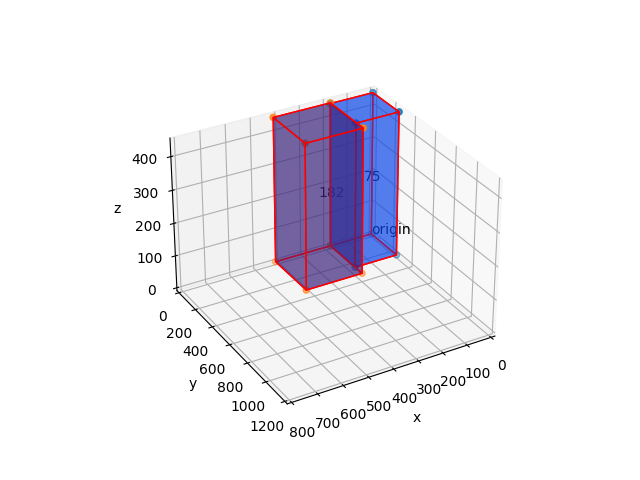

In [44]:
example = total_layer_pool[50]
ax = plot.get_pallet(config.pallet_lenght, config.pallet_width, example[0])
for s_id, s_coords in zip(example[1], example[2]):
    dims = superitems.iloc[s_id].lenght, superitems.iloc[s_id].width, superitems.iloc[s_id].height
    ax = plot.add_product_to_pallet(ax, s_id, (s_coords[0], s_coords[1], 0), dims)
    plt.show()

## Warm start without height groups

In [141]:
zsl, ol = warm_start.warm_start_no_groups(
    superitems, config.pallet_lenght, config.pallet_width
)
zsl, ol

(array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],


In [140]:
zsl, ol = warm_start.warm_start(
    len(superitems), initial_groups, config.pallet_lenght, config.pallet_width
)
zsl, ol

IndexError: index 91 is out of bounds for axis 0 with size 60

In [142]:
fsi = layers.items_assignment(superitems)
fsi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [ ]:
layer_pool = column_generation(
    fsi, zsl, ol, ws, ds, hs, 
    config.pallet_lenght, config.pallet_width, tlim=None
)

  0%|          | 0/20 [00:00<?, ?it/s]

Solving RMP...


In [95]:
layer_pool

[(1.0,
  1097.0000000000002,
  array([ 2, 14, 19, 31]),
  array([[  0.,   0.],
         [  0., 118.],
         [240., 494.],
         [ 84., 494.]])),
 (1.0,
  756.0000000000001,
  array([ 1,  4,  7, 20, 21, 24]),
  array([[ 19.,   0.],
         [152., 499.],
         [  0., 254.],
         [ 19., 254.],
         [304., 254.],
         [  0., 109.]])),
 (1.0, 232.0, array([8]), array([[0., 0.]])),
 (0.5,
  1619.9999999999998,
  array([ 9, 12, 27, 29]),
  array([[  0., 894.],
         [563.,   0.],
         [  0., 549.],
         [  0.,  87.]])),
 (0.5,
  1019.0000000000001,
  array([10, 16, 26, 28]),
  array([[  0.,   0.],
         [  0., 747.],
         [628.,   0.],
         [ 21.,   0.]])),
 (0.5,
  1543.0000000000002,
  array([13, 30]),
  array([[  0.,   0.],
         [160.,   0.]])),
 (0.3333333333333333,
  356.99999999999994,
  array([ 6, 22, 25]),
  array([[  0., 184.],
         [  0.,   0.],
         [  0., 368.]]))]

<IPython.core.display.Javascript object>


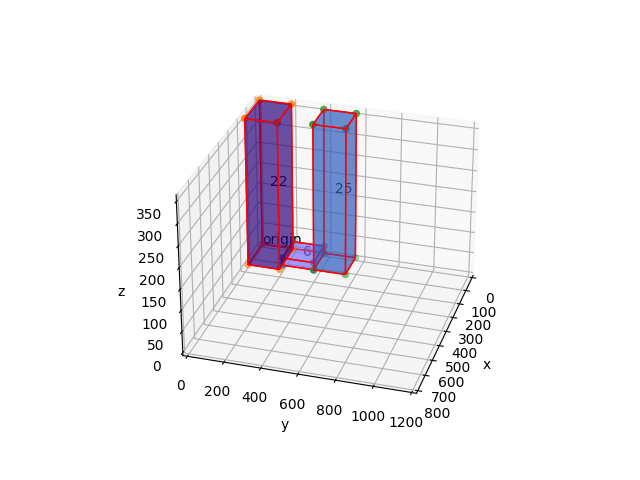

In [104]:
example = layer_pool[6]
ax = plot.get_pallet(config.pallet_lenght, config.pallet_width, example[1])
for s_id, s_coords in zip(example[2], example[3]):
    dims = superitems.iloc[s_id].lenght, superitems.iloc[s_id].width, superitems.iloc[s_id].height
    ax = plot.add_product_to_pallet(ax, s_id, (s_coords[0], s_coords[1], 0), dims)
    plt.show()